# Import the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from catboost import CatBoostClassifier
#import h2o
#from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline 

# Read the datasets

In [ ]:
data = pd.read_csv("../train.csv")

data.head()

In [ ]:
test = pd.read_csv("../test.csv")

test.head()

# count of each class

In [ ]:
data["label"].value_counts()

# Data Cleaning

# Check for duplicated rows, then remove

print (sum(data.duplicated()))

data[data.duplicated()]

print(data.shape)

data.drop_duplicates(inplace=True)

print (data.shape)

Check the data type of each column and do necessary changes

In [ ]:
data.dtypes

In [5]:
data["pickup_time"] = pd.to_datetime(data["pickup_time"])
data["drop_time"] = pd.to_datetime(data["drop_time"])
data["label"] = data["label"].apply(lambda x: 1 if x=="correct" else 0)

test["pickup_time"] = pd.to_datetime(test["pickup_time"])
test["drop_time"] = pd.to_datetime(test["drop_time"])

# Null Value handling

In [6]:
data[data["label"]==1].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495
unique,1,2,2,2,2,2,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,15495,15442,15442,15442,15442,15442,15495,15495,15495,15495,15495,15495,15495,15495


In [7]:
data[data["label"]==0].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681
unique,1,2,2,2,2,2,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1681,1532,1532,1532,1532,1532,1681,1681,1681,1681,1681,1681,1544,1681


In [8]:
test.isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576


Fill the Cells with NaN with the mean value of that column

In [9]:
data["additional_fare"].fillna(data["additional_fare"].mean() , inplace=True)
data["duration"].fillna(data["duration"].mean() , inplace=True)
data["meter_waiting"].fillna(data["meter_waiting"].mean() , inplace=True)
data["meter_waiting_fare"].fillna(data["meter_waiting_fare"].mean() , inplace=True)
data["meter_waiting_till_pickup"].fillna(data["meter_waiting_till_pickup"].mean() , inplace=True)
data["fare"].fillna(data["fare"].mean() , inplace=True)

# EDA

Let's Explore the distribution of each featue

In [ ]:
data.iloc[:,1:].hist(figsize=(20,20) , bins=100)

In [ ]:
test.iloc[:,1:].hist(figsize=(20,20) , bins=100)

In [ ]:
data.corr()

# Remove outliers

Let's Plot boxplot to see there any outliers

column_names = list(data.columns)
column_names.remove("pickup_time")
column_names.remove("drop_time")
column_names.remove("tripid")
column_names.remove("label")
for i in column_names:
    sn.boxplot(data[i])
    plt.show()

Q1 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.05)
Q3 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.95)
IQR = Q3 - Q1
print(IQR)

print((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR)))

data = data[~((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)]

data.shape

# Feature Engineering

Create new features from the existing features
    pickup_time_minuts - number of minutes past from 12 AM 
    Distance - Euclidean distance using longitude and latitude

In [10]:
data["pickup_time_minuts"] = data["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
data["distance"] = ((data["pick_lat"]-data["drop_lat"])**2 + (data["pick_lon"] - data["drop_lon"])**2 )**0.5

#data["drop_time_minuts"] = data["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#data["pickup_day"] = data["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#data["drop_day"] = data["drop_time"].apply(lambda x: int(x.strftime("%w")))
#data["pickup_month"] = data["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#data["drop_month"] = data["drop_time"].apply(lambda x: int(x.strftime("%m")))



test["pickup_time_minuts"] = test["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
test["distance"] = ((test["pick_lat"]-test["drop_lat"])**2 + (test["pick_lon"] - test["drop_lon"])**2 )**0.5

#test["drop_time_minuts"] = test["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#test["pickup_day"] = test["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#test["drop_day"] = test["drop_time"].apply(lambda x: int(x.strftime("%w")))
#test["pickup_month"] = test["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#test["drop_month"] = test["drop_time"].apply(lambda x: int(x.strftime("%m")))


    date_diff - difference of drop and pickup time in seconds

In [11]:
data["date_diff"] = data['drop_time'] - data['pickup_time']
data['date_diff']=data['date_diff']/np.timedelta64(1,'s')

test["date_diff"] = test['drop_time'] - test['pickup_time']
test['date_diff']=test['date_diff']/np.timedelta64(1,'s')

data["tot_time"] = data["meter_waiting_till_pickup"] + data["meter_waiting"]
test["tot_time"] = test["meter_waiting_till_pickup"] + test["meter_waiting"]
data["tot_fare"] = data["additional_fare"] + data["meter_waiting_fare"] + data["fare"]
test["tot_fare"] = test["additional_fare"] + test["meter_waiting_fare"] + test["fare"]


In [12]:
data.drop(["tripid" , "pickup_time" , "drop_time" , "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat"], axis=1, inplace=True)

test.drop(["tripid" , "pickup_time" , "drop_time"  , "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat"], axis=1, inplace=True)

# Get the featue importance

Feature ranking:
1. fare 5 (0.213008)
2. duration 1 (0.171910)
3. pickup_time_minuts 7 (0.150030)
4. distance 8 (0.149720)
5. meter_waiting 2 (0.097040)
6. meter_waiting_till_pickup 4 (0.061760)
7. label 6 (0.061384)
8. meter_waiting_fare 3 (0.060611)
9. additional_fare 0 (0.034538)


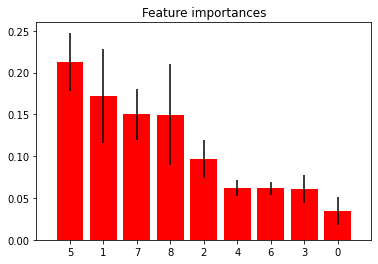

In [13]:
tree_cls = RandomForestClassifier()

tree_cls.fit(data.drop(["label"],axis=1),data["label"])

importances = tree_cls.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_cls.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]-1):
    print("%d. %s %d (%f)" % (f + 1,data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]-1), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]-1), indices)
plt.xlim([-1, data.shape[1]-1])
plt.show()

data.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

test.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

data.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)

test.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)


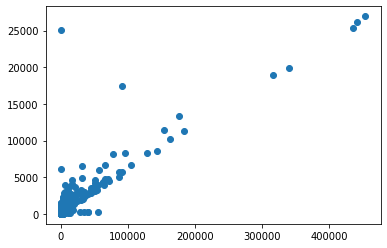

In [14]:
plt.scatter(data["date_diff"] , data["fare"])

# Splitting the dataset

In [15]:
X = data.drop(["label"],axis=1)
scale = MinMaxScaler()

X = scale.fit_transform(X)

Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print (y_train.value_counts())
print(y_test.value_counts())


1    12371
0     1369
Name: label, dtype: int64
1    3124
0     312
Name: label, dtype: int64


# Training and Prediction

# XGBoost Classifier

In [18]:
xg_clf = xgboost.XGBClassifier(n_estimators = 1000)

cv = cross_validate(xg_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score=True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

[0.97973917 0.97748797 0.97904052 0.98004968]
Mean Accuracy(Training) :  0.9790793355069088
[0.99793477 0.99767662 0.99767662 0.99853726]
Mean Recall Score(Training) :  0.997956317501572
[0.97997296 0.97781901 0.97947115 0.97973829]
Mean Precision Score(Training) :  0.9792503512796926
[0.98887231 0.98764801 0.98849007 0.98904845]
Mean F1 Score(Training) :  0.9885147094876886
[0.94410806 0.95551933 0.94946437 0.94340941]
Mean Accuracy Score(Testing) :  0.9481252911038659
[0.97857512 0.99199793 0.98709344 0.9883811 ]
Mean recall Score(Testing) :  0.9865118986254469
[0.96023303 0.96002998 0.95815585 0.95081967]
Mean Precision Score(Testing) :  0.9573096324234924
[0.96931731 0.97575219 0.97240941 0.96923661]
Mean F1 Score(Testing) :  0.9716788802683295


In [16]:
clf = xgboost.XGBClassifier(n_estimators = 1000)

clf.fit(X_train,y_train)

pred = clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

[[ 198  114]
 [  37 3087]]
0.9761264822134387
[[ 1076   293]
 [   31 12340]]
0.9870420732682771


In [20]:
t_pred = clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../xg_0614_null_values_filled_with_mean_three_extra.csv" , index=False)

# Random Forest Classifier

In [ ]:
rf1_clf = RandomForestClassifier(n_estimators=1000 )

cv = cross_validate(rf1_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score = True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=1000)

rf_clf.fit(X_train,y_train)

pred = rf_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = rf_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

t_pred = rf_clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../late_9.csv" , index=False)

Manually checking the misclassified data samples

In [ ]:
pred_cv = rf_clf.predict(X)

data["pred"] = pred_cv

data1 = data[data["pred"]!= data["label"] ]

data1


In [ ]:
data1["label"].value_counts()

In [ ]:
data1.describe()

# Gradient Boosting Classifier

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=1000 , max_depth=8, min_samples_split=2)

gb_clf.fit(X_train,y_train)

pred = gb_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = gb_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Logistic Regression Classifier

In [ ]:
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)

pred = lr_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = lr_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Naive Bayes Classifier with Gaussian 

In [ ]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train,y_train)

pred = gnb_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred = gnb_clf.predict(X_train)

print (confusion_matrix(y_train,pred))

print (f1_score(y_train,pred))


# Classification with multi layer perseptron ( Neural Networks )

In [ ]:
mlp_clf = MLPClassifier(activation='relu', solver='sgd' , verbose=True , early_stopping=False , tol= 10**-20)

mlp_clf.fit(X_train,y_train)

pred = mlp_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = mlp_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Cat boost classifier

In [ ]:
cat_clas = CatBoostClassifier(loss_function = 'Logloss')
#iterations=9000, depth=8, learning_rate=0.01, loss_function='Logloss')
#cat_clas.fit(X_train, y_train)

param_grid = {'learning_rate': [0.03, 0.1 , 0.01 ],
            'depth': [4, 6, 10 , 15],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'iterations' : [5000, 9000 , 13000 , 17000]}

grid_search_result = cat_clas.grid_search(param_grid,
            X_train,
            y_train,
            cv=4,
            partition_random_seed=0,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot=True)

In [ ]:
pred = cat_clas.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = cat_clas.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

In [ ]:
h2o.init()

gbm_classifier = H2OGradientBoostingEstimator(distribution="multinomial", ntrees=10, max_depth=3, min_rows=2, learn_rate=0.2)

gbm_classifier.train(x=X_train , y=y_train)